In [1]:
from platform import python_version
print("Python: " + python_version())
import tensorflow as tf
print("Tensorflow: " + tf.__version__)
from tensorflow import keras
from os import walk
import numpy as np
from os import walk
import time
import matplotlib
from matplotlib import pyplot as plt
import cv2  #OpenCV 
import os
import glob
import pandas as pd
import regex as re
import h5py

Python: 3.9.0
Tensorflow: 2.7.0


__Global Variables__

In [2]:
SD_imbalance_hdf5 = "D:/UoH_PhD_Exp/Data/Data_HDF/SD_Imbalanced_Data.h5"
SD_balance_hdf5 = "D:/UoH_PhD_Exp/Data/Data_HDF/SD_balanced_Data.h5"

__GPU Configuration__

In [3]:
import warnings

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found")
else:
    print("Default GPU device: {}".format(tf.test.gpu_device_name()))
    
print("Num Devices Available: ", len(tf.config.experimental.list_physical_devices()))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Default GPU device: /device:GPU:0
Num Devices Available:  2
Num CPUs Available:  1
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1660630292957383714
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2909195470
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3379536116027728306
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


__Read HDF5 Data__

In [4]:
def read_many_hdf5(num_images, file_path):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(file_path, "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

__Loss Accuracy Curve__

In [5]:
def loss_accuracy_curves(history):
    ############### printing accuracy and loss between the epoches #########
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label ="Validation")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label ="Validation")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

__Ostu Thresholding/Binarisation__

In [6]:
def ostu_thd(XX):
    rnd_images = []
    for img in XX:
        #img = rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Otsu's thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        rnd_images.append(th2)
    test_images = np.array(rnd_images)
    
    return test_images

__Train and Test Split + Reshaping Data to adjust greyscal dimension__

In [7]:
import scipy._lib
from sklearn.model_selection import train_test_split

def pre_process(X, y):
    
    # test_size is the test size of the total dataset, random_state controls the shuffling of data. same state returns same data always.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=786, stratify=y) 
    print("Total training intences: " + str(len(y_train)))
    print("Train Data:" + str(np.unique(y_train, return_counts=True)))
    print("Total testing intences: " + str(len(y_test)))
    print("Test Data:" + str(np.unique(y_test, return_counts=True)))

    print("Before Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 58, 120, 1))
    X_test = X_test.reshape((X_test.shape[0], 58, 120, 1))
    print("After Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    
    # Convert the array to float32 as opposed to uint8
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    X_train /= 255
    X_test /=  255

    NUM_DIGITS = 2

    print("Before", y_train[0]) # The format of the labels before conversion

    y_train  = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

    print("After", y_train[0]) # The format of the labels after conversion

    y_test = tf.keras.utils.to_categorical(y_test, NUM_DIGITS)
    
    return X_train, X_test, y_train, y_test

## Models

__Model1__

In [8]:
def model_1c1p1f1d1d():
    
    np.random.seed(786)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu', input_shape=(58, 120,1)))
    model.add(tf.keras.layers.MaxPool2D(strides=10))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(320, activation=tf.nn.relu))#, input_shape=(28500,)))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    # We will now compile and print out a summary of our model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.01),
                  metrics=['accuracy'])

    print(model.summary())
    return model

__Model 2__

In [9]:
def model_2c2p1f2d1d():
    
    np.random.seed(786)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(58, 120,1)))
    model.add(tf.keras.layers.MaxPool2D(strides=10))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(320, activation=tf.nn.relu))#, input_shape=(28500,)))
    model.add(tf.keras.layers.Dense(280, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    # We will now compile and print out a summary of our model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.0001),
                  metrics=['accuracy'])

    print(model.summary())
    return model

__Model 3__

In [10]:
def model_3c3p1f2d1d():
    
    np.random.seed(786)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(58, 120,1)))
    model.add(tf.keras.layers.MaxPool2D(strides=10))
    model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(320, activation=tf.nn.relu))#, input_shape=(28500,)))
    model.add(tf.keras.layers.Dense(280, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    # We will now compile and print out a summary of our model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

    print(model.summary())
    return model

## Main Execution Body

### 1) Imbalanced Dataset
#### 1.1) Model 1

Total X intences: (5832, 58, 120)
Total y intences: 5832
Total Normal images in imbalanced dataset: 4968
Total distorted images in imbalanced dataset: 864
Total training intences: 4082
Train Data:(array([0, 1], dtype=uint8), array([3477,  605], dtype=int64))
Total testing intences: 1750
Test Data:(array([0, 1], dtype=uint8), array([1491,  259], dtype=int64))
Before Reshaping the shape of train and test dataset:
(4082, 58, 120)
(1750, 58, 120)
After Reshaping the shape of train and test dataset:
(4082, 58, 120, 1)
(1750, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 120, 64)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 12, 64)        0         
 )                                                               
                       

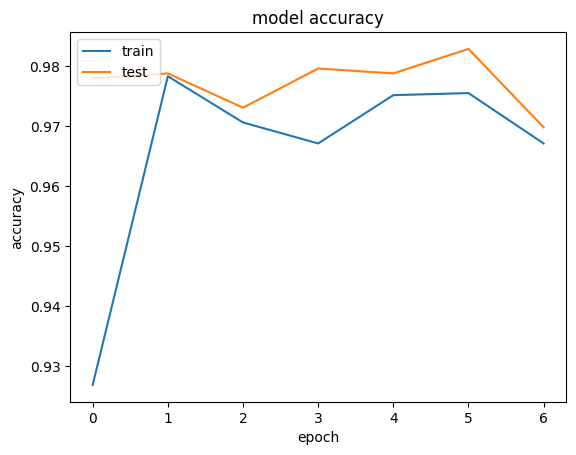

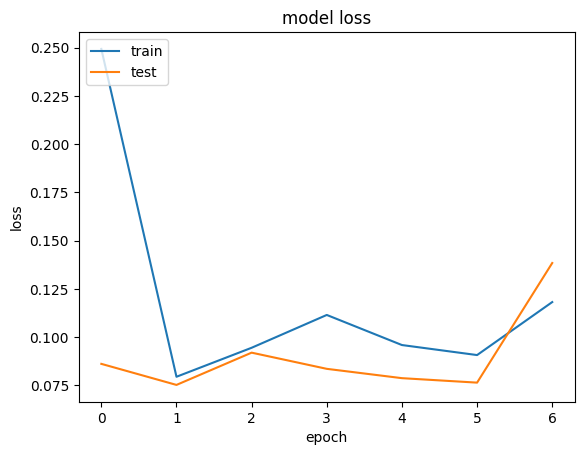

In [11]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_imbalance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in imbalanced dataset: " + str(my_count[0]))
print("Total distorted images in imbalanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model1 = model_1c1p1f1d1d()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history1 = model1.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history1)
########### Evaluate model
loss1, accuracy1 = model1.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy1))
print('Test loss: %.2f' % (loss1))
########## Classification Report
y_pred1 = model1.predict(X_test)
y_actual1 = np.argmax(y_test,axis=1)
print(y_actual1[0:25])
y_pred1 = np.argmax(y_pred1,axis=1)
print(y_pred1[0:25])

print(classification_report(y_actual1,y_pred1))
print(confusion_matrix(y_actual1,y_pred1))
print(accuracy_score(y_actual1,y_pred1))

################# PLot Loss accuracy curves
loss_accuracy_curves(history1)

#### 1.2) Model 2

Total X intences: (5832, 58, 120)
Total y intences: 5832
Total Normal images in imbalanced dataset: 4968
Total distorted images in imbalanced dataset: 864
Total training intences: 4082
Train Data:(array([0, 1], dtype=uint8), array([3477,  605], dtype=int64))
Total testing intences: 1750
Test Data:(array([0, 1], dtype=uint8), array([1491,  259], dtype=int64))
Before Reshaping the shape of train and test dataset:
(4082, 58, 120)
(1750, 58, 120)
After Reshaping the shape of train and test dataset:
(4082, 58, 120, 1)
(1750, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 58, 120, 64)       640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 12, 64)        0         
 2D)                                                             
                     

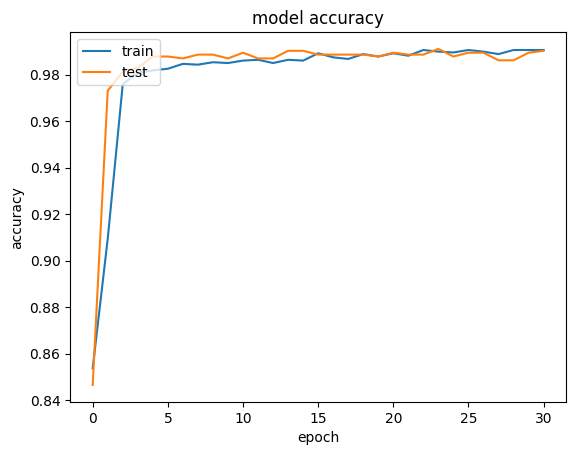

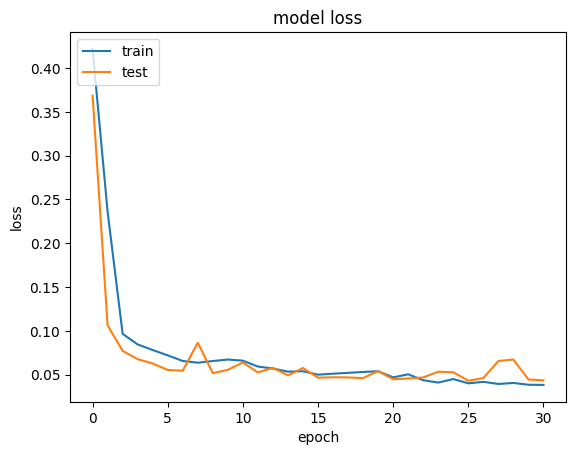

In [12]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_imbalance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in imbalanced dataset: " + str(my_count[0]))
print("Total distorted images in imbalanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model2 = model_2c2p1f2d1d()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history2 = model2.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history2)
########### Evaluate model
loss2, accuracy2 = model2.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy2))
print('Test loss: %.2f' % (loss2))
########## Classification Report
y_pred2 = model2.predict(X_test)
y_actual2 = np.argmax(y_test,axis=1)
print(y_actual2[0:25])
y_pred2 = np.argmax(y_pred2,axis=1)
print(y_pred2[0:25])

print(classification_report(y_actual2,y_pred2))
print(confusion_matrix(y_actual2,y_pred2))
print(accuracy_score(y_actual2,y_pred2))

################# PLot Loss accuracy curves
loss_accuracy_curves(history2)

#### 1.3) Model 3

Total X intences: (5832, 58, 120)
Total y intences: 5832
Total Normal images in imbalanced dataset: 4968
Total distorted images in imbalanced dataset: 864
Total training intences: 4082
Train Data:(array([0, 1], dtype=uint8), array([3477,  605], dtype=int64))
Total testing intences: 1750
Test Data:(array([0, 1], dtype=uint8), array([1491,  259], dtype=int64))
Before Reshaping the shape of train and test dataset:
(4082, 58, 120)
(1750, 58, 120)
After Reshaping the shape of train and test dataset:
(4082, 58, 120, 1)
(1750, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 58, 120, 64)       1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 12, 64)        0         
 2D)                                                             
                     

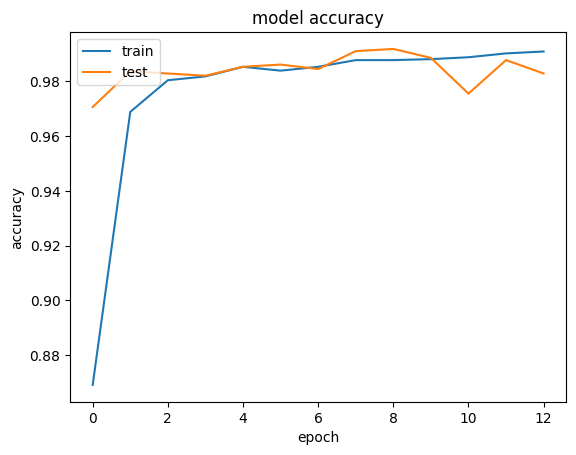

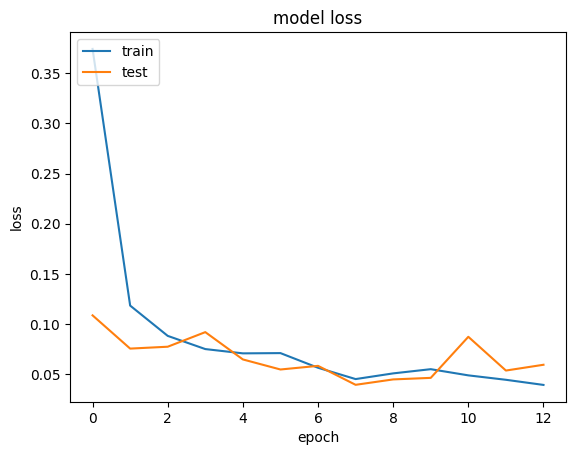

In [13]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_imbalance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in imbalanced dataset: " + str(my_count[0]))
print("Total distorted images in imbalanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model3 = model_3c3p1f2d1d()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history3 = model3.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history3)
########### Evaluate model
loss3, accuracy3 = model3.evaluate(X_test, y_test)
print('Test accuracy: %.3f' % (accuracy3))
print('Test loss: %.3f' % (loss3))
########## Classification Report
y_pred3 = model3.predict(X_test)
y_actual3 = np.argmax(y_test,axis=1)
print(y_actual3[0:25])
y_pred3 = np.argmax(y_pred3,axis=1)
print(y_pred3[0:25])

print(classification_report(y_actual3,y_pred3))
print(confusion_matrix(y_actual3,y_pred3))
print(accuracy_score(y_actual3,y_pred3))

################# PLot Loss accuracy curves
loss_accuracy_curves(history3)

## Model performance comparison

In [30]:
### storing classification report as dictionary and accessing each element in the report
report = classification_report(y_actual3,y_pred3, output_dict=True)
macro_precision =  report['macro avg']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']
accuracy = report['accuracy']

print("Model accuracy: ", accuracy)
print("Precision of surface deformed calss: ", report['1']['precision'])
print("Recall of surface deformed calss: ", report['1']['recall'])

report1 = classification_report(y_actual1,y_pred1, output_dict=True)
report2 = classification_report(y_actual2,y_pred2, output_dict=True)
report3 = classification_report(y_actual3,y_pred3, output_dict=True)

ls_precision_sd = [report1['1']['precision'], report2['1']['precision'], report3['1']['precision']]
ls_recall_sd = [report1['1']['recall'], report2['1']['recall'], report3['1']['recall']]

Model accuracy:  0.988
Precision of surface deformed calss:  0.9958333333333333
Recall of surface deformed calss:  0.9227799227799228


__1 Accuracy Comparison__

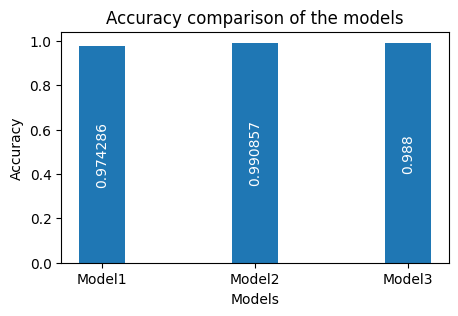

In [31]:
labels = ['Model1', 'Model2', 'Model3']
ls_acc = [accuracy1, accuracy2, accuracy3]

fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.bar(labels, ls_acc, width = 0.3)
ax1.bar_label(ax1.containers[0], label_type='center', rotation=90, color='white')

########### Labels
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison of the models")
#plt.grid()
plt.show()

__2 Loss Comparison__

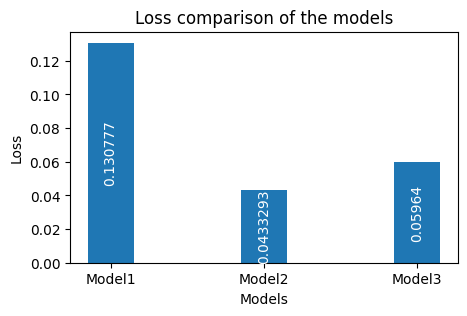

In [32]:
labels = ['Model1', 'Model2', 'Model3']
ls_loss = [loss1, loss2, loss3]

fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.bar(labels, ls_loss, width = 0.3)
ax1.bar_label(ax1.containers[0], label_type='center', rotation=90, color='white')

########### Labels
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Loss comparison of the models")
#plt.grid()
plt.show()

__3 Precision Comparison__

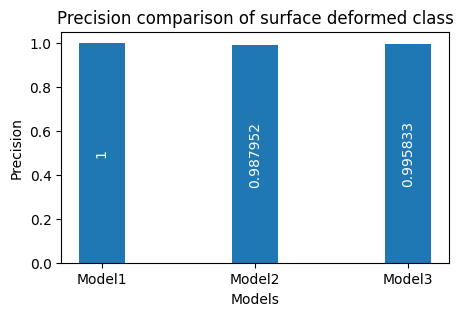

In [33]:
labels = ['Model1', 'Model2', 'Model3']
ls_pre = ls_precision_sd #[accuracy1, accuracy2, accuracy3]

fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.bar(labels, ls_pre, width = 0.3)
ax1.bar_label(ax1.containers[0], label_type='center', rotation=90, color='white')

########### Labels
plt.xlabel("Models")
plt.ylabel("Precision")
plt.title("Precision comparison of surface deformed class")
#plt.grid()
plt.show()

__4 Recall Comparison__

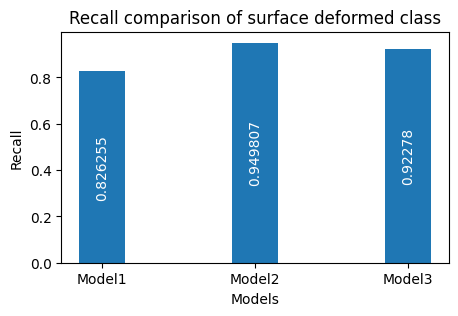

In [34]:
labels = ['Model1', 'Model2', 'Model3']
ls_recall = ls_recall_sd # [loss1,loss2,loss3]

fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.bar(labels, ls_recall, width = 0.3)
ax1.bar_label(ax1.containers[0], label_type='center', rotation=90, color='white')

########### Labels
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Recall comparison of surface deformed class")
#plt.grid()
plt.show()

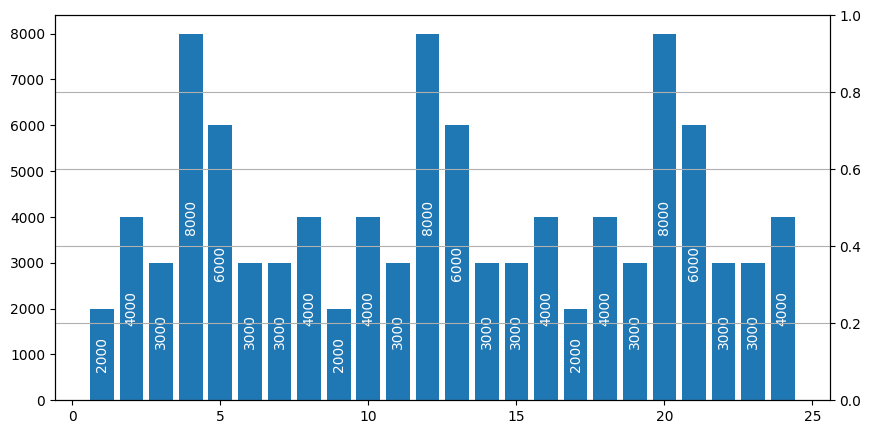

In [35]:
a = [2000, 4000, 3000, 8000, 6000, 3000, 3000, 4000, 2000, 4000, 3000, 8000, 6000, 3000, 3000, 4000, 2000, 4000, 3000, 8000, 6000, 3000, 3000, 4000]
b = [0.8, 0.9, 0.83, 0.81, 0.86, 0.89, 0.89, 0.8, 0.8, 0.9, 0.83, 0.81, 0.86, 0.89, 0.89, 0.8, 0.8, 0.9, 0.83, 0.81, 0.86, 0.89, 0.89, 0.8]
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

fig1, ax1 = plt.subplots(figsize=(10, 5))
ax12 = ax1.twinx()

ax1.bar(c, a)
#ax12.plot(c, b, 'o-', color="red", markersize=12, markerfacecolor='Yellow', markeredgewidth=2, linewidth=2)
#ax12.set_ylim(bottom=0, top=1, emit=True, auto=False)
ax1.bar_label(ax1.containers[0], label_type='center', rotation=90, color='white')

plt.grid()
plt.show()

### 2) Balanced Dataset

> The model3 outperformed the model1 and model2 in terms of accuracy and loss. So, we will stick with model3 for our further experiments.
<br>

#### 2.1) Model 1

Total X intences: (5460, 58, 120)
Total y intences: 5460
Total Normal images in balanced dataset: 2868
Total distorted images in balanced dataset: 2592
Total training intences: 3822
Train Data:(array([0, 1], dtype=uint8), array([2008, 1814], dtype=int64))
Total testing intences: 1638
Test Data:(array([0, 1], dtype=uint8), array([860, 778], dtype=int64))
Before Reshaping the shape of train and test dataset:
(3822, 58, 120)
(1638, 58, 120)
After Reshaping the shape of train and test dataset:
(3822, 58, 120, 1)
(1638, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 58, 120, 64)       320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 12, 64)        0         
 g2D)                                                            
                          

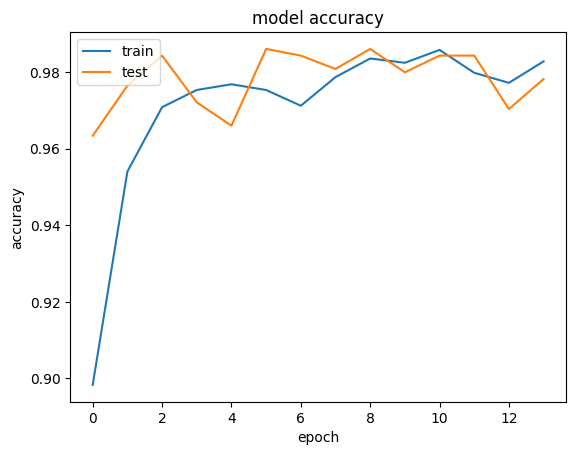

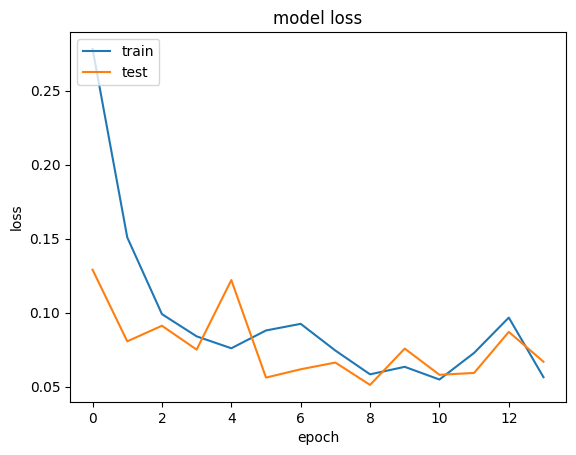

In [40]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_balance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in balanced dataset: " + str(my_count[0]))
print("Total distorted images in balanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model1 = model_1c1p1f1d1d()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history1 = model1.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history1)
########### Evaluate model
loss1, accuracy1 = model1.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy1))
print('Test loss: %.2f' % (loss1))
########## Classification Report
y_pred1 = model1.predict(X_test)
y_actual1 = np.argmax(y_test,axis=1)
print(y_actual1[0:25])
y_pred1 = np.argmax(y_pred1,axis=1)
print(y_pred1[0:25])

print(classification_report(y_actual1,y_pred1))
print(confusion_matrix(y_actual1,y_pred1))
print(accuracy_score(y_actual1,y_pred1))

################# PLot Loss accuracy curves
loss_accuracy_curves(history1)

#### 2.1) Model 2

Total X intences: (5460, 58, 120)
Total y intences: 5460
Total Normal images in balanced dataset: 2868
Total distorted images in balanced dataset: 2592
Total training intences: 3822
Train Data:(array([0, 1], dtype=uint8), array([2008, 1814], dtype=int64))
Total testing intences: 1638
Test Data:(array([0, 1], dtype=uint8), array([860, 778], dtype=int64))
Before Reshaping the shape of train and test dataset:
(3822, 58, 120)
(1638, 58, 120)
After Reshaping the shape of train and test dataset:
(3822, 58, 120, 1)
(1638, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 58, 120, 64)       640       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 6, 12, 64)        0         
 g2D)                                                            
                          

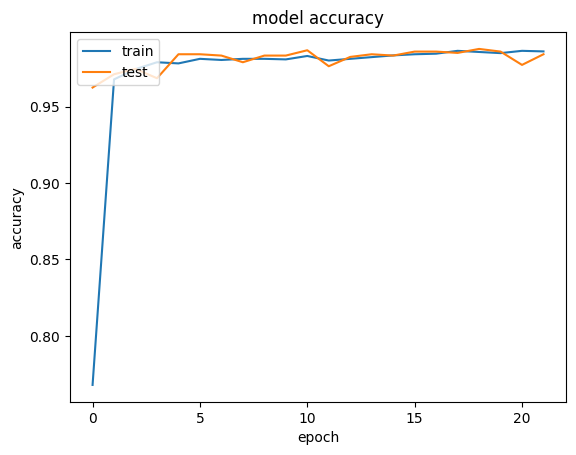

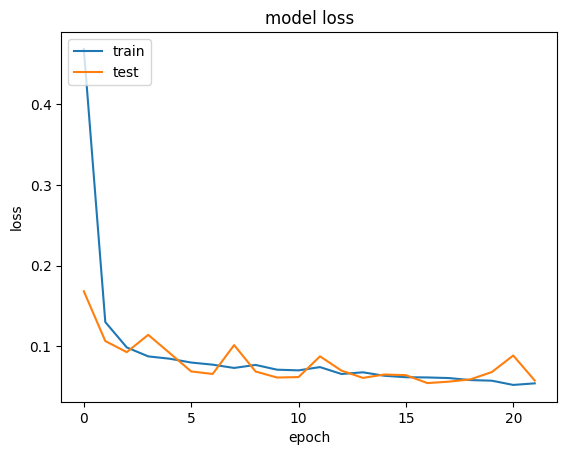

In [41]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_balance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in balanced dataset: " + str(my_count[0]))
print("Total distorted images in balanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model2 = model_2c2p1f2d1d()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history2 = model2.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history2)
########### Evaluate model
loss2, accuracy2 = model2.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy2))
print('Test loss: %.2f' % (loss2))
########## Classification Report
y_pred2 = model2.predict(X_test)
y_actual2 = np.argmax(y_test,axis=1)
print(y_actual2[0:25])
y_pred2 = np.argmax(y_pred2,axis=1)
print(y_pred2[0:25])

print(classification_report(y_actual2,y_pred2))
print(confusion_matrix(y_actual2,y_pred2))
print(accuracy_score(y_actual2,y_pred2))

################# PLot Loss accuracy curves
loss_accuracy_curves(history2)

#### 2.2) Model 3

Total X intences: (5460, 58, 120)
Total y intences: 5460
Total Normal images in balanced dataset: 2868
Total distorted images in balanced dataset: 2592
Total training intences: 3822
Train Data:(array([0, 1], dtype=uint8), array([2008, 1814], dtype=int64))
Total testing intences: 1638
Test Data:(array([0, 1], dtype=uint8), array([860, 778], dtype=int64))
Before Reshaping the shape of train and test dataset:
(3822, 58, 120)
(1638, 58, 120)
After Reshaping the shape of train and test dataset:
(3822, 58, 120, 1)
(1638, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 58, 120, 64)       1664      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 12, 64)        0         
 g2D)                                                            
                          

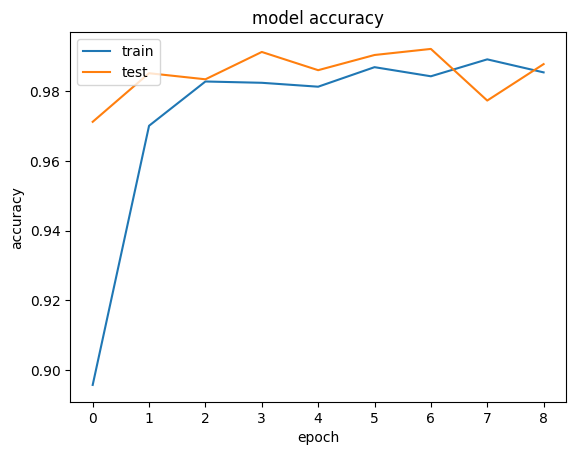

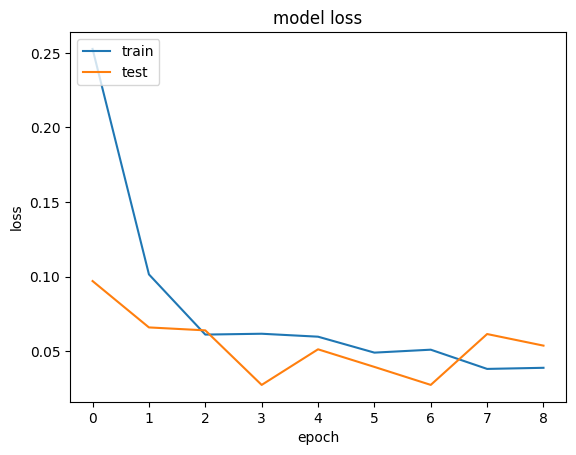

In [42]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_balance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in balanced dataset: " + str(my_count[0]))
print("Total distorted images in balanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model3 = model_3c3p1f2d1d()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history3 = model3.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history3)
########### Evaluate model
loss3, accuracy3 = model3.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy3))
print('Test loss: %.2f' % (loss3))
########## Classification Report
y_pred3 = model3.predict(X_test)
y_actual3 = np.argmax(y_test,axis=1)
print(y_actual3[0:25])
y_pred3 = np.argmax(y_pred3,axis=1)
print(y_pred3[0:25])

print(classification_report(y_actual3,y_pred3))
print(confusion_matrix(y_actual3,y_pred3))
print(accuracy_score(y_actual3,y_pred3))

################# PLot Loss accuracy curves
loss_accuracy_curves(history3)

In [43]:
### storing classification report as dictionary and accessing each element in the report

report1 = classification_report(y_actual1,y_pred1, output_dict=True)
report2 = classification_report(y_actual2,y_pred2, output_dict=True)
report3 = classification_report(y_actual3,y_pred3, output_dict=True)

ls_acc = [accuracy1, accuracy2, accuracy3]
ls_loss = [loss1, loss2, loss3]
ls_pre = [report1['1']['precision'], report2['1']['precision'], report3['1']['precision']]
ls_recall = [report1['1']['recall'], report2['1']['recall'], report3['1']['recall']]

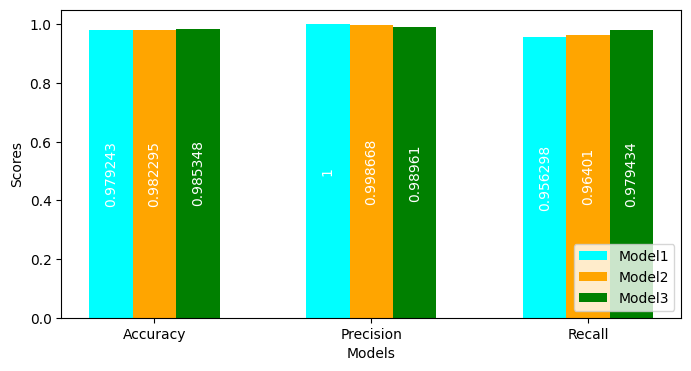

In [74]:
# create data
x = np.arange(3)
y1 = [accuracy1,report1['1']['precision'],report1['1']['recall'] ] #[accuracy, precision, recall]
y2 = [accuracy2,report2['1']['precision'],report2['1']['recall'] ]
y3 = [accuracy3,report3['1']['precision'],report3['1']['recall'] ]

width = 0.2

fig1, ax1 = plt.subplots(figsize=(8, 4))
# plot data in grouped manner of bar type
ax1.bar(x-0.2, y1, width, color='cyan')
ax1.bar_label(ax1.containers[0], label_type='center', rotation=90, color='white')
ax1.bar(x, y2, width, color='orange')
ax1.bar_label(ax1.containers[1], label_type='center', rotation=90, color='white')
ax1.bar(x+0.2, y3, width, color='green')
ax1.bar_label(ax1.containers[2], label_type='center', rotation=90, color='white')
#ax1.bar(x+0.4, ls_recall, width, color='red')
#ax1.bar_label(ax1.containers[3], label_type='center', rotation=90, color='white')
plt.xticks(x, ["Accuracy", "Precision", "Recall"])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(['Model1', 'Model2', 'Model3'], loc = 4)
plt.show()

In [75]:
'''
# create data
x = np.arange(5)
y1 = [34, 56, 12, 89, 67]
y2 = [12, 56, 78, 45, 90]
y3 = [14, 23, 45, 25, 89]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['Team A', 'Team B', 'Team C', 'Team D', 'Team E'])
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.legend(["Round 1", "Round 2", "Round 3"])
plt.show()
'''

'\n# create data\nx = np.arange(5)\ny1 = [34, 56, 12, 89, 67]\ny2 = [12, 56, 78, 45, 90]\ny3 = [14, 23, 45, 25, 89]\nwidth = 0.2\n  \n# plot data in grouped manner of bar type\nplt.bar(x-0.2, y1, width, color=\'cyan\')\nplt.bar(x, y2, width, color=\'orange\')\nplt.bar(x+0.2, y3, width, color=\'green\')\nplt.xticks(x, [\'Team A\', \'Team B\', \'Team C\', \'Team D\', \'Team E\'])\nplt.xlabel("Teams")\nplt.ylabel("Scores")\nplt.legend(["Round 1", "Round 2", "Round 3"])\nplt.show()\n'

### Visualisations

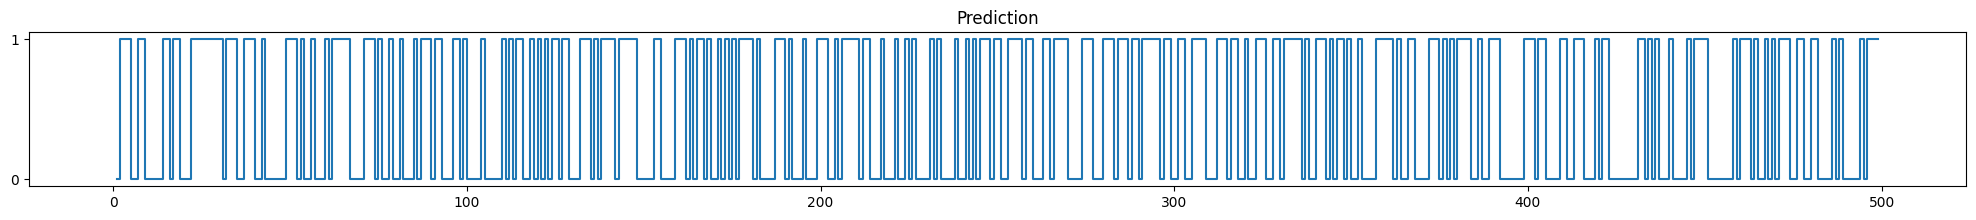

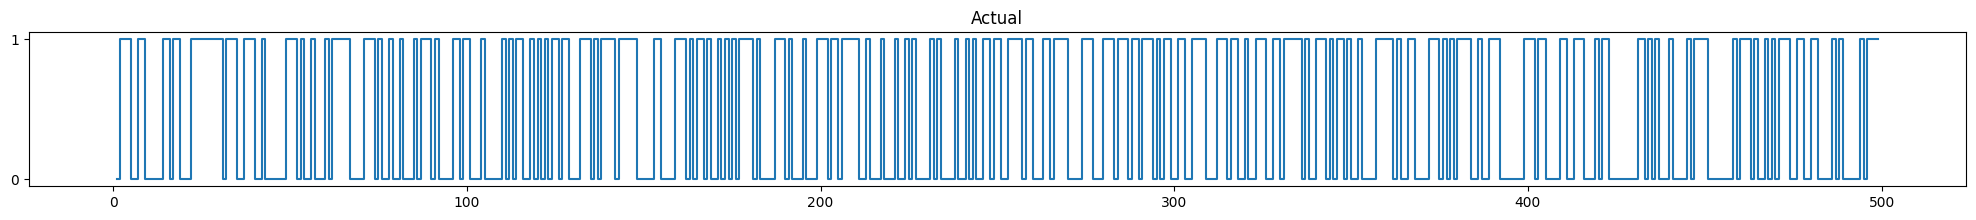

In [76]:
y_pred_temp = y_pred[1:500]
y1 = range(1, len(y_pred_temp)+1)
plt.figure(figsize=(25,2))
plt.step(y1, y_pred_temp)
plt.xticks([0,100,200,300,400,500])
plt.yticks([0,1])
plt.title("Prediction")
plt.show()

y_pred_temp = y_actual[1:500]
y1 = range(1, len(y_pred_temp)+1)
plt.figure(figsize=(25,2))
plt.step(y1, y_pred_temp)
plt.xticks([0,100,200,300,400,500])
plt.yticks([0,1])
plt.title("Actual")
plt.show()

### ROC curves of  model3

In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_actual3, y_pred3)
print(fpr1, tpr1, thresh1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_actual3))]
p_fpr, p_tpr, _ = roc_curve(y_actual3, random_probs, pos_label=1)


# auc scores
auc_score1 = roc_auc_score(y_actual3, y_pred3)
print(auc_score1)

[0.         0.00930233 1.        ] [0.         0.97943445 1.        ] [2 1 0]
0.985066060859688


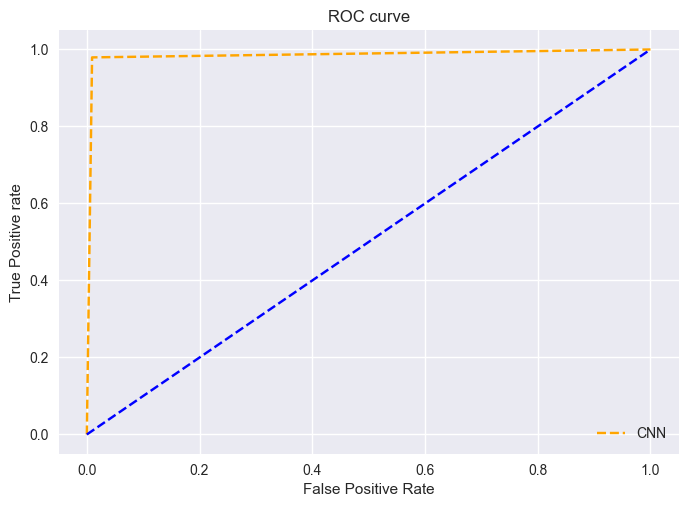

In [78]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();